# Lab 3: PID Tracking and Disturbance Rejection

Type name here

Monday 1:25pm section

Table #

## Contents:

1. [Pre-lab Questions](#prelab)
1. [Lab Procedure](#lab)
1. [Post-lab Questions](#postlab)
1. [Submissions](#sub)

## Learning Objectives

1. Implement P, PI, and PID control laws on motor-propeller systems
2. Determine the effects of controller parameters on closed-loop station keeping while rejecting disturbances
3. Determine the effects of controller parameters on closed-loop tracking while rejecting disturbances

<a id='prelab'></a>

## Pre-lab Questions

In this lab, you will design feedback controllers to balance a pinned arm using a propeller at the tip, as shown in the following figure.

<img src="https://github.com/AdaWick/MEEG312/blob/master/Lab3/Rotating%20arm.png?raw=true" width="600" />

This system is inherently unstable: the arm will not remain horizontal unless there is a thrust force to balance the moment due to gravity.  The equations of motion (EOMs) can be found by taking a sum of moments about the pin (axis of rotation):

$\sum M_0 = J \ddot{\theta} = -b \dot{\theta} - mgR_0\cos(\theta) + TR$

which, upon rearranging, gives

$J \ddot{\theta} + b \dot{\theta} + mgR_0\cos(\theta) = TR$

This is a non-linear second-order ODE.  Moreover, the thrust $T$ is dependent on the distance $d$ to the ground, which is a function of the angle of the arm $\theta$.  Indeed, the closer the fan is to the ground, the more thrust it generates for a given fan speed.  More details about this system's dynamics are given in the Lab 3 simulator notebook.

In this lab, you will utilize PID control laws for **station keeping** and **disturbance rejection**.  For station keeping, you have a "set point" of operation in mind, and you want to keep the system near that set point depite outside disturbances, noise, and/or uncertainty.  Imagine trying to draw a straight line while someone is shaking your arm.  This can be quantitatively defined as "staying between the lines", where the lines represent the maximum allowable error, or perhaps one or more standard deviations of allowable error:

<img src="https://github.com/AdaWick/MEEG312/blob/master/Lab3/Station%20keeping.png?raw=true" width="600" />

Feedback control, like PID, is necessary because it is impossible to predict the random disturbances the system might face.  For example, the automatic flight control in an airplane is able to maintain the aircraft in a horizontal orientation dispite random turbulence it may be subjected to.

Disturbance rejection means restoring the system to equilibrium (or within some bounds of equilibrium) quickly and efficiently after a random, unpredictable disturbance:

<img src="https://github.com/AdaWick/MEEG312/blob/master/Lab3/Disturbance%20rejection.png?raw=true" width="600" />

Impacts, large gusts of wind, and sudden accelertions are all types of disturbances.  For measuring the quality of disturbance rejection, we will use the same measures as Lab 2 for the step response: things like rise time, settling time, and overshoot.

For measuring the quality of station keeping, we will need a new calculation.  Specifically, we will use a common measure called the [root-mean square (RMS)](https://en.wikipedia.org/wiki/Root_mean_square) of the error, where, as in Lab 2, the error is the difference between where the system is and where we want it to be.  The formula for RMS is

$e_{RMS} = \sqrt{\dfrac{1}{n}(e^2[0] + e^2[1] + \dotsb + e^2[n])}$,

where $n$ is the total number of data points (i.e. simulation time steps).

The RMS error is always positive and can only be 0 if the error is exactly 0 for all time steps.

The RMS error gives a useful measure of error, but it does not indicate any *cause* for the error.  We will also investigate measures of how well a system can "keep up" with the commands it's given.  Matching these measures with theory will gives us an indication of why the system is lagging behind and what the controller can do to compensate.

Image you have two sinusoids, one representing the desired trajectory and one representing the actual path of the system.  Calculating the phase difference between the sinusoids is a measure of the lead or lag of the system.  As we will see in Lab 4, if the system has a phase lag in its response, a phase lead in the controller can make up for that.

So, how do we measure phase lag when the signals are not exactly sinusoids.  The following equations give a robust (not sensitive to noise or outliers) means of calculating an effective phase of a periodic signal.  It basically comes down to fitting a sine wave to each signal and then computing the phase difference between the two fits.

<img src="https://github.com/AdaWick/MEEG312/blob/master/Lab4/Phase%20difference.png?raw=true" width="600" />

To compute the amplitude of a periodic waveform, a naïve approach would be to average all of the peaks’ amplitudes; however, this method does not work if the signal is noisy or irregular unless you have a large number of cycles to average over. The following method incorporates all of the signal data, not just the “peaks”:

Let \\(y(t) = Y \sin(\omega t)\\).  Then

\\(\dfrac{1}{T} \displaystyle\int_0^T y^2(t)dt = \dfrac{Y^2}{T} \int_0^T \left[ \dfrac{1}{2} + \dfrac{1}{2} \sin(2 \omega t + 2 \phi) \right] dt \to \dfrac{Y^2}{2}\\) as \\(T \to \infty\\)

Although the actual output \\(y(t)\\) will not in general be an exact sine wave (since it will be corrupted by noise, sensor quantization, and unmodeled dynamics), we can use this formula to define an effective "amplitude" for the signal:

\\(Y = \sqrt{\dfrac{2}{T} \displaystyle\int_0^T y^2(t)dt}\\)

This can be discretized as

\\(Y = \sqrt{\dfrac{2}{N} \displaystyle\sum\limits_{i=1}^N y^2[i]} \:\:\:\:\:\:\:(1)\\)

where \\(N\\) is the number of data points in the signal.

Similarly, we can show

\\(\dfrac{1}{T} \displaystyle\int_0^T \sin(\omega t)y(t)dt = \dfrac{Y}{T} \int_0^T \left[ \dfrac{1}{2}\cos(\phi) + \dfrac{1}{2} \sin(2 \omega t)\cos(\phi) \right] dt \to \dfrac{Y}{2}\cos(\phi)\\) as \\(T \to \infty\\), and

\\(\dfrac{1}{T} \displaystyle\int_0^T \cos(\omega t)y(t)dt = \dfrac{Y}{T} \int_0^T \left[ \dfrac{1}{2}\sin(\phi) + \dfrac{1}{2} \sin(2 \omega t)\cos(\phi) \right] dt \to \dfrac{Y}{2}\sin(\phi)\\) as \\(T \to \infty\\)

Although the actual output \\(y(t)\\) will not in general be an exact sine wave, we can use this formula to define an effective "phase" for the signal:

\\(\cos(\phi) = \dfrac{2}{YT} \displaystyle\int_0^T \sin(\omega t)y(t)dt\\) and \\(\sin(\phi) = \dfrac{2}{YT} \displaystyle\int_0^T \cos(\omega t)y(t)dt\\)

These can be discretized as

\\(A = \dfrac{2}{YN} \displaystyle\sum\limits_{i=1}^N \sin(\omega t[i])y[i]\\) and \\(B = \dfrac{2}{YN} \displaystyle\sum\limits_{i=1}^N \cos(\omega t[i])y[i]  \:\:\:\:\:\:\:(2)\\)

Then

\\(\phi = \text{arctan2}(B,A)  \:\:\:\:\:\:\:(3)\\)

which gives us the full 360 deg. of angle.  Note that you want to use the [arctan2 function](https://numpy.org/doc/stable/reference/generated/numpy.arctan2.html).  The arctan function does not return angles outside the range \\(\pm 90\\)deg. 

The $\omega$ in Equation (2) is your best estimate of the frequency (in rad/s) of the signal.  You can calculate that using the average period between peaks using the `find_peaks` function.  (See Lab 1 and the Background module notebook Peak_Analysis.)

**Problem 1 (10 points):**

Add code to compute the RMS error of the system's position vs. time loaded from the provided data set `test3.txt`.  This is an actual data set recorded in lab.  Position is measured in volts measured by the Hall effect sensor, which measures the distance of the back end of the pivoting arm from the ground.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as ss

0.041210896959044875


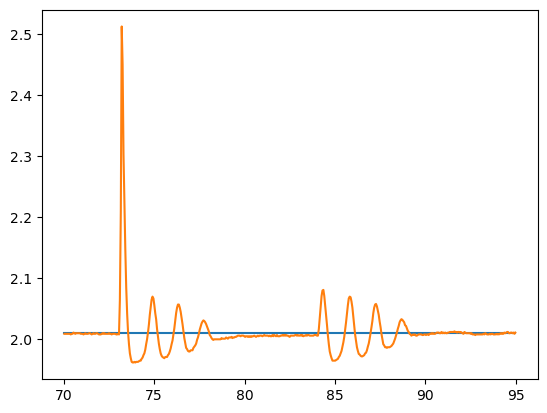

In [2]:
# read data from text file, skipping first row
data = np.genfromtxt('test3.txt',skip_header=1)
t = data[:,0]     # time is column 1 (recall column numbering starts at 0)
r = data[:,2]     # desired (reference) position is column 3
x = data[:,3]     # actual position is column 4
plt.plot(t,r,t,x)

# compute RMS error (input your code here)
RMS = np.sqrt(np.mean((x-r)**2))
print(RMS)

**Problem 2 (20 points):**

In the empty cell below, add code to compute the effective amplitude (Equation 1 above) and phase (Equations 2-3 above) for the reference position `r`.  These equations assume the mean value of `r` is 0, so your first step should be to subtract off the mean value of `r`.

Then repeat these calculations for the actual position `x`.

Subtract the phase of `r` from the phase of `x` to get the phase lag of `x` with respect to `r`.

-0.16253859170647691


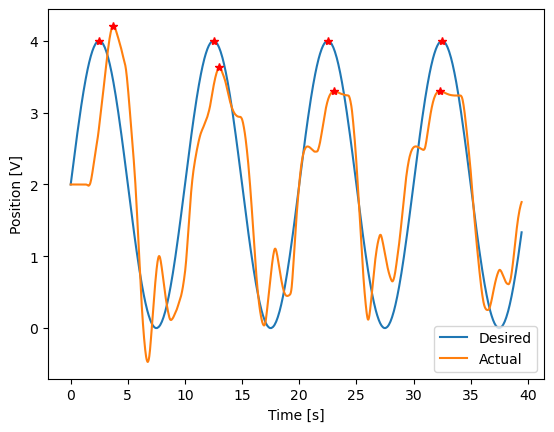

In [3]:
# read data from text file, skipping first row
data = np.genfromtxt('test3s.txt',skip_header=1)
t = data[:,0]     # time is column 1 (recall column numbering starts at 0)
r = data[:,2]     # desired (reference) position is column 3
x = data[:,3]     # actual position is column 4
plt.plot(t,r,label='Desired')
plt.plot(t,x,label='Actual')
plt.ylabel('Position [V]')
plt.xlabel('Time [s]')
plt.legend()

# Effective Amplitude
peaks,_ = ss.find_peaks(r,prominence=1.0)
amp = np.sqrt(2*np.mean(r**2)) #Using Eq (1)
# print(amp)
plt.plot(t[peaks], r[peaks], "r*")
p = np.mean(t[peaks][1:-1] - t[peaks][0:-2])
f = 1/p

Ar = 2/amp * np.mean(np.sin(f * t)*r) #Using Eq (2,3)
Br = 2/amp * np.mean(np.cos(f * t)*r)
phir = np.arctan2(Br,Ar)
# print(Ar, Br, phir)

# For X
peaks,_ = ss.find_peaks(x,prominence=1.0)
amp = np.sqrt(2*np.mean(x**2)) #Using Eq (1)
# print(amp)
plt.plot(t[peaks], x[peaks], "r*")
p = np.mean(t[peaks][1:-1] - t[peaks][0:-2])
f = 1/p

Ax = 2/amp * np.mean(np.sin(f * t)*x) #Using Eq (2,3)
Bx = 2/amp * np.mean(np.cos(f * t)*x)
phix = np.arctan2(Bx,Ax)
# print(Ax, Bx, phix)

print(phix-phir)

plt.show()

<a id='lab'></a>

## Lab Procedure

In this lab, you will use the myVTOL National Instruments (NI) miniSystem by Pitsco Education, the NI myDAQ data acquisition device, and NI LabVIEW software to design a  to hover, track trajectories, and reject disturbances. The myVTOL system uses a variable-speed PC cooling fan to create the lift for the one degree of freedom (DOF) system. The angle of the arm the fan is mounted on is measured using an analog Hall Effect sensor that responds to a changing magnetic field by varying voltage output.

**In-person labs:**

1. On a flat surface, plug the myVTOL (green circuit board) into the myDAQ (beige box).  The connector can only fit one way, and the connector will be flush with the body of the DAQ when properly connected.
2. Plug the AC adaptor into a power outlet and connect the to the myVTOL board.  (Do not use the 9V battery.)
3. Set the switch on the myVTOL to ON.
4. Connect the myDAQ to the computer using the USB cable.  The blue LED should light up on the myDAQ next to the USB cable port.
5. Copy the file `MEEG312 Lab 3.llb` from Canvas to the computer's desktop, if it is not already there.  Double-click it to open it.  This library contains all of the LabView Virtual Instruments (VIs) we will use for this lab.

**Online labs**

Open the file "Lab 3 simulator.ipynp" in a separate tab.

1. This file is divided into three parts.  These parts correspond to the in-person lab Parts.

2. In Part 1, you can control the system in real time using your mouse.  You can stop the control at any time by clicking the stop button next to the animation.

3. In Part 2, input the parameters for each experiment.  In particular, you will be changing the controller gains according the procedures of Part 2 below.

4. Part 3 is similar to Part 2 except the reference is a sine wave instead of a constant.  You will be changing the controller gains according the procedures of Part 3 below.

4. Once you have settled on new PID gains for sinusoidal tracking, reuse these gains in Part 2 (hover).  Save this simulation to compare to your original PID gains.

4. In Parts 1-3, optionally save an image of the plot of the arm's motion.

5. In Parts 1-3, run the last cell to save your data into a text file.  It will prompt you for a file name.  You should not add the ".txt" to the file name; this will be added automatically.  **Be sure to do this after every simulation you want to save.  If you don't, your data will be overwritten.**

### Part 1: Manual Control

First, you will try to stabilize and track a sinusoidal trajectory manually, using your mouse or keyboard to change the motor voltage.  This will give you an idea how difficult controlling a barely stable system can be!

1. Open the VI `MEEG312 - Manual Control.vi`.
1. Click the white arrow in the upper left hand corner of the window to run the VI.
1. Use the page up/page down keys or use the mouse to slide the manual fan power control level up and down to control the output voltage to the fan and get the Hall effect sensor voltage within the target range.  The arm should move easily to the top of its range of motion if you give it the max voltage (10 V).  You  may need to wiggle the arm if it gets stuck against the support and/or adjust the position of the counterweight.
1. Try to balance the fan arm so that it is parallel to the table.  Copy the "Sensor Reading" voltage into the "Target Sensor Reading" voltage box.
1. Give the fan arm a small disturbance.  Note how it recovers (or doesn't).  Press the "Stop" button to choose a filename and save.  Don't worry if there is data in the file you don't want to plot later; you can always trim the data later in Python.
1. Now click the moving target button.  Try to manually control the fan so that it tracks the given sinusoid.  The indicator will turn bright green when you’re in range.
1. Try to capture three "good" (or "pretty good") cycles of oscillation while tracking the sinusoid as best you can.  Each person should try this and save their results.  **Briefly reflect on the challenges of manually controlling this system.**
1. When you're finished with this part, close the VI.

### Part 2: PID Control

In this part, you will design a PID controller to hold a given angle (hover).  While doing this, you will test the stability and evaluate the closed-loop performance by delivering manual disturbances to the system.

1. Open the VI `MEEG312 - PIDControl.vi`.
1. Set all of the "PID Gain Settings" to 0 to start.
1. Set the "Control Mode" button to "Manual".  Run the VI by clicking the white arrow in the upper left hand corner.  Adjust the fan voltage until the arm is parallel to the table.  Again, you may need to wiggle the arm so that it rotates smoothly.
1. Copy the "Sensor Reading" voltage into the "Target Sensor Reading" voltage box.
1. Now, switch the "Control Mode" button to "PID".  Gradually increase the Proportional gain.  **Explain what happens as you increase the gain in terms of steady-state error.  Try deflecting the arm and watch the response.**
1. Save a few trials at different proportional gains by hitting the "Stop" button and saving the data.  **Record your gain settings because the data file does not save them.**
1. Now first try increasing the Integral gain and then the Derivative gain.  You will probably need a small Integral gain and a large Derivative gain compared to your Proportional gain.
1. For each gain setting, give the arm a small tap and see how it responds.  You will use these transient responses to characterize your controller in terms of rise time, overshoot, etc.
1. Again, save a few trials for different gain combinations by hitting the "Stop" button and saving the data.  **Record your gain settings because the data file does not save them.**


### Part 3: PID Control Sinusoidal Tracking

In this part, you will activate the "Moving Target", which means instead of just hovering, the system will have to track a sinusoidal trajectory.  You will most likely have to re-tune you PID control gains since this is a much more difficult task for the controller.

1. Now, press the "Moving Target" button.  The arm will try to track a sinusoidal motion.  Save the response after a few cycles.
1. Change your PID gains to get a better tracking response.  Record this response, capturing at least 2 cycles.  De-select the "Moving Target" button and see how it responds to disturbances.  Does this controller do better than the one you settled on at the end of Part 2?
1. When you're finished with this part, close the VI.

**Turn off the myVTOL and unplug everything once you are finished.  Put the system back in the black case and the instructor/TA will collect it.**

<a id='postlab'></a>

## Post-lab Questions

1. For the manual control case (Part 1), describe the challenges in controlling the system.  Include plots of your personal trial.  Describe what you see and match that to your experience controlling the system.

1. Describe how varying the gains -- proportional, integral, and derivative -- of the controller affects its closed-loop response to disturbances.  Use as many plots and trials as needed to sufficiently support your discussion.

1. Compute the RMS error for Part 2 when there were no disturbances (the "baseline").

1. When there was a disturbance, compute the settling time, i.e. the time it took for the system to return to the baseline from the moment of the disturbance.  Your code should automatically calculate this, meaning you should not have to look at the plot and estimate the time yourself.

1. For Part 3, calculate the RMS error over 2 cycles.  Most likely, it will be significantly larger than the RMS error from Part 2, but this is to be expected since tracking a sine wave is more difficult that tracking a constant.

1. For Part 3, calculate the amplitude of the actual motion and its phase lag with respect to the reference sine wave.

At the end, please write a conclusion paragraph (or two) summarizing your results and outlining how a PID controller could be designed for this myVTOL system.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as ss

1:
    It was challenging to perfectly match the desired position. You can see this in the large error between the desired and actual value.

Text(0, 0.5, 'Position (V)')

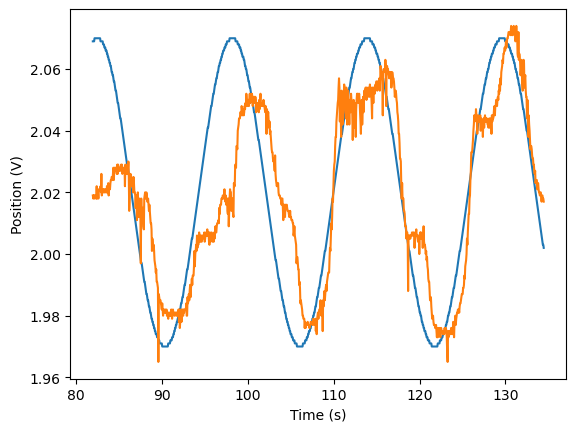

In [11]:
# read data from text file, skipping first row
data = np.genfromtxt('Isaac Pt1.txt',skip_header=1)
t = data[:,0][1640:]     # time is column 1 (recall column numbering starts at 0)
r = data[:,2][1640:]     # desired (reference) position is column 3
x = data[:,3][1640:]     # actual position is column 4
plt.plot(t,r,t,x)
plt.xlabel("Time (s)")
plt.ylabel("Position (V)")

2:
- Proportional control affects how strongly the system reacts to a disturbance. You can see this in the reaction to the disturbance around T = 65.5 sec, this is the result of a high P that causes the system to overshoot.
- Integral control affects how much steady state error there is. In the same disturbance, we can see the system slowy return to a low steady state error, this is due to the I gain.
- Derivative control affects how quickly a system responds to a disturbance. When responding to the disturbance, the system immediately responds, this is due to a high D.

Text(0, 0.5, 'Position (V)')

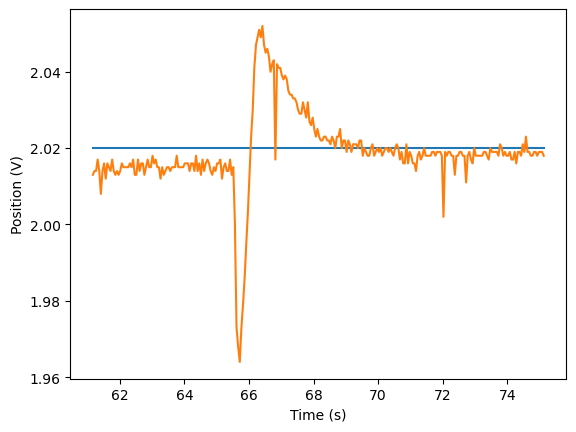

In [15]:
# read data from text file, skipping first row
data = np.genfromtxt('Part2B.txt',skip_header=1)
t = data[:,0][1220:1500]     # time is column 1 (recall column numbering starts at 0)
r = data[:,2][1220:1500]     # desired (reference) position is column 3
x = data[:,3][1220:1500]     # actual position is column 4
plt.plot(t,r,t,x)
plt.xlabel("Time (s)")
plt.ylabel("Position (V)")

RMS = 0.009920853457910491


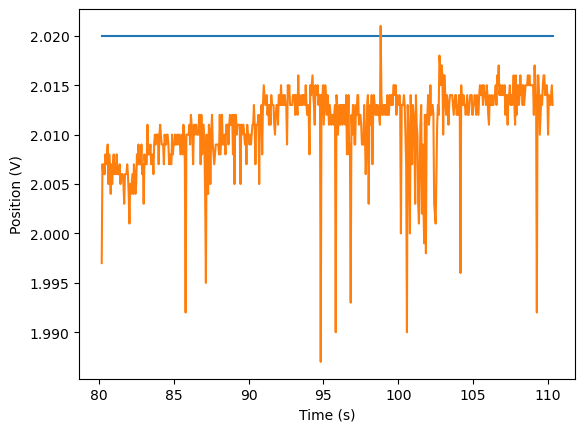

In [19]:
# 3
# read data from text file, skipping first row
data = np.genfromtxt('Part2B.txt',skip_header=1)
t = data[:,0][1600:2200]     # time is column 1 (recall column numbering starts at 0)
r = data[:,2][1600:2200]     # desired (reference) position is column 3
x = data[:,3][1600:2200]     # actual position is column 4
plt.plot(t,r,t,x)
plt.xlabel("Time (s)")
plt.ylabel("Position (V)")

RMS = np.sqrt(np.mean((x-r)**2))
print(f"RMS = {RMS}")

Settle Time = [2.958] sec


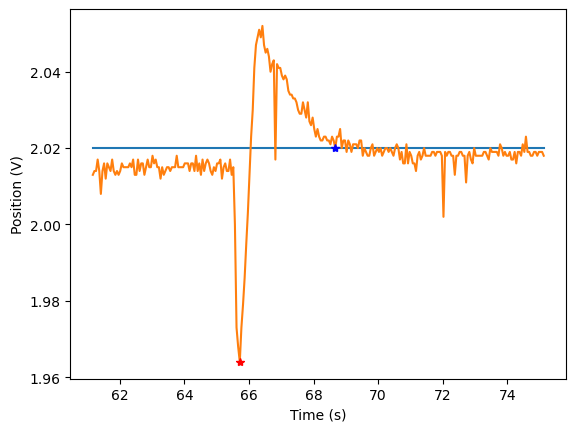

In [12]:
# 4

# read data from text file, skipping first row
data = np.genfromtxt('Part2B.txt',skip_header=1)
t = data[:,0][1220:1500]     # time is column 1 (recall column numbering starts at 0)
r = data[:,2][1220:1500]     # desired (reference) position is column 3
x = data[:,3][1220:1500]     # actual position is column 4
plt.plot(t,r,t,x)
plt.xlabel("Time (s)")
plt.ylabel("Position (V)")

# Find Disturbance
disturbance, _ = ss.find_peaks(-x, prominence=.05)
plt.plot(t[disturbance],x[disturbance], "r*")

# Find Settle Point
point = disturbance[0]
while x[point] > r[point] or x[point+50] > r[point+50]:
    point = point + 1
plt.plot(t[point], x[point], "b*")

print(f"Settle Time = {np.abs(t[disturbance] - t[point])} sec")



RMS = 0.013387520841653781


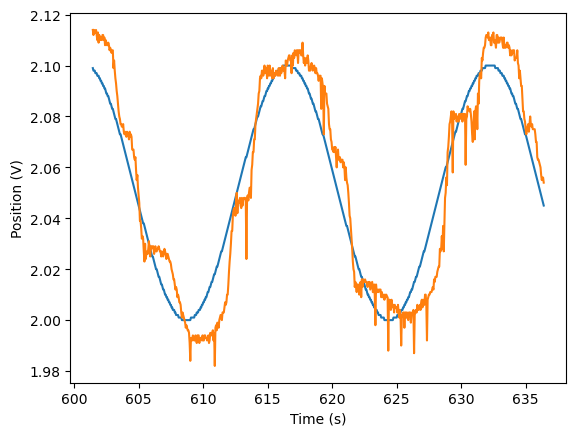

In [21]:
# 5

data = np.genfromtxt('Part3_PT2.txt',skip_header=1)
t = data[:,0][12000:12700]    # time is column 1 (recall column numbering starts at 0)
r = data[:,2][12000:12700]    # desired (reference) position is column 3
x = data[:,3][12000:12700]    # actual position is column 4
plt.plot(t,r,t,x)
plt.xlabel("Time (s)")
plt.ylabel("Position (V)")

RMS = np.sqrt(np.mean((x-r)**2))
print(f"RMS = {RMS}")

1.5635396401324817


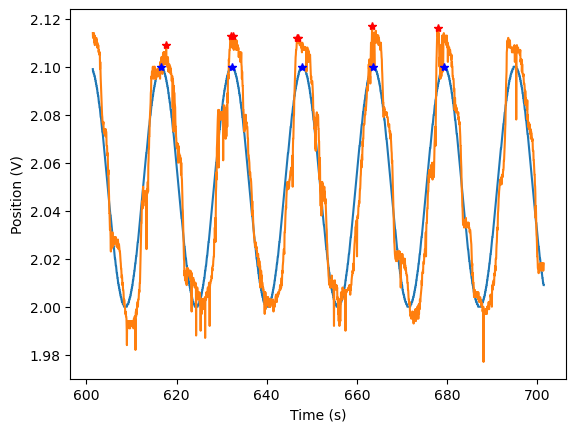

In [37]:
# 6

ata = np.genfromtxt('Part3_PT1.txt',skip_header=1)
t = data[:,0][12000:14000]    # time is column 1 (recall column numbering starts at 0)
r = data[:,2][12000:14000]    # desired (reference) position is column 3
x = data[:,3][12000:14000]    # actual position is column 4
plt.plot(t,r,t,x)
plt.xlabel("Time (s)")
plt.ylabel("Position (V)")

# # X Valleys/Peaks
# xpeaks, _ = ss.find_peaks(x, prominence=.1)
# plt.plot(t[xpeaks],x[xpeaks], "r*")
# xvalleys, _ = ss.find_peaks(-x, prominence=.1)
# plt.plot(t[xvalleys],x[xvalleys], "r*")

# # R Valleys/Peaks
# rpeaks, _ = ss.find_peaks(r)
# plt.plot(t[rpeaks],r[rpeaks], "b*")
# rvalleys, _ = ss.find_peaks(-r)
# plt.plot(t[rvalleys],r[rvalleys], "b*")

# Effective Amplitude
peaks,_ = ss.find_peaks(r,prominence=.1)
amp = np.sqrt(2*np.mean(r**2)) #Using Eq (1)
# print(amp)
plt.plot(t[peaks], r[peaks], "b*")
p = np.mean(t[peaks][1:-1] - t[peaks][0:-2])
f = 1/p

Ar = 2/amp * np.mean(np.sin(f * t)*r) #Using Eq (2,3)
Br = 2/amp * np.mean(np.cos(f * t)*r)
phir = np.arctan2(Br,Ar)
# print(Ar, Br, phir)

# For X
peaks,_ = ss.find_peaks(x,prominence=.1)
amp = np.sqrt(2*np.mean(x**2)) #Using Eq (1)
# print(amp)
plt.plot(t[peaks], x[peaks], "r*")
p = np.mean(t[peaks][1:-1] - t[peaks][0:-2])
f = 1/p

Ax = 2/amp * np.mean(np.sin(f * t)*x) #Using Eq (2,3)
Bx = 2/amp * np.mean(np.cos(f * t)*x)
phix = np.arctan2(Bx,Ax)
# print(Ax, Bx, phix)

print(phix-phir)

plt.show()



PID Controller for the MyVTOL System: To design a PID controller for this system, one can tune it by hand to get an adequate controller. Another option is to use a PID tuning program through MATLAB or some other program. An ideal system would be state-based, where if a disturbance is detected a particular controller is activated, then a different controller is activated to achieve a steady-state.


<a id='sub'></a>

## Submissions

Please submit the following on Canvas:

1. Your completed Jupyter notebook (this file)
2. All data (.txt) files
3. All screen captures (they can be embedded in the Jupyter notebook or saved as separate files)

Please label your data files and screen captures in a logical manner so that they can be correlated.